In [1]:
"""
Know more, visit my Python tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
tensorflow: 1.1.0
matplotlib
numpy
"""

'\nKnow more, visit my Python tutorial page: https://morvanzhou.github.io/tutorials/\nMy Youtube Channel: https://www.youtube.com/user/MorvanZhou\nDependencies:\ntensorflow: 1.1.0\nmatplotlib\nnumpy\n'

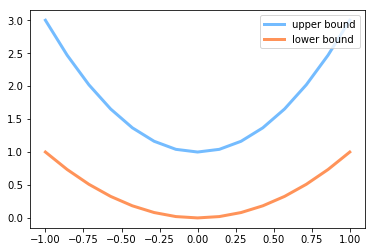

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.set_random_seed(1)
np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])

# show our beautiful painting range
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()

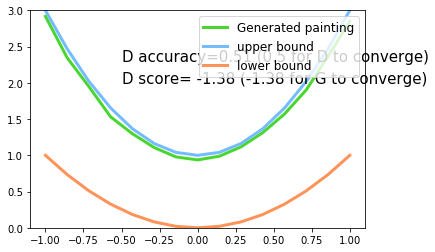

In [3]:
def artist_works():     # painting from the famous artist (real target)
    a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    paintings = a * np.power(PAINT_POINTS, 2) + (a-1)
    return paintings


with tf.variable_scope('Generator'):
    G_in = tf.placeholder(tf.float32, [None, N_IDEAS])          # random ideas (could from normal distribution)
    G_l1 = tf.layers.dense(G_in, 128, tf.nn.relu)
    G_out = tf.layers.dense(G_l1, ART_COMPONENTS)               # making a painting from these random ideas

with tf.variable_scope('Discriminator'):
    real_art = tf.placeholder(tf.float32, [None, ART_COMPONENTS], name='real_in')   # receive art work from the famous artist
    D_l0 = tf.layers.dense(real_art, 128, tf.nn.relu, name='l')
    prob_artist0 = tf.layers.dense(D_l0, 1, tf.nn.sigmoid, name='out')              # probability that the art work is made by artist
    # reuse layers for generator
    D_l1 = tf.layers.dense(G_out, 128, tf.nn.relu, name='l', reuse=True)            # receive art work from a newbie like G
    prob_artist1 = tf.layers.dense(D_l1, 1, tf.nn.sigmoid, name='out', reuse=True)  # probability that the art work is made by artist

D_loss = -tf.reduce_mean(tf.log(prob_artist0) + tf.log(1-prob_artist1))
G_loss = tf.reduce_mean(tf.log(1-prob_artist1))

train_D = tf.train.AdamOptimizer(LR_D).minimize(
    D_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator'))
train_G = tf.train.AdamOptimizer(LR_G).minimize(
    G_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator'))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

plt.ion()   # something about continuous plotting
for step in range(5000):
    artist_paintings = artist_works()           # real painting from artist
    G_ideas = np.random.randn(BATCH_SIZE, N_IDEAS)
    G_paintings, pa0, Dl = sess.run([G_out, prob_artist0, D_loss, train_D, train_G],    # train and get results
                                    {G_in: G_ideas, real_art: artist_paintings})[:3]

    if step % 50 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % pa0.mean(), fontdict={'size': 15})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -Dl, fontdict={'size': 15})
        plt.ylim((0, 3)); plt.legend(loc='upper right', fontsize=12); plt.draw(); plt.pause(0.01)

plt.ioff()
plt.show()